# Execute all versions of lid driven cavity problem

In [15]:
from pathlib import Path
from xml.etree import ElementTree
path = "bin"
programs = {
    "Lid driven cavity": ("SparseLUWrapper", "SparseLUWrapper"),
    "Lid driven cavity QR GPU": ("QR", "SparseLUWrapper"),
    # "Lid driven cavity iterative GPU" : "lidDrivenIterativeGPU" # useless...
    "Lid driven cavity GPU with DSS" : ("DSS", "SparseLUWrapper"),
    "Lid driven cavity GPU with DSS and RF" : ("DSS", "RF")
}
hs = [h/1000.0 for h in range(20, 6, -2)]

Create parameter files

In [16]:
def get_output_path(program, h):
    return Path("benchmark", f"lidDriven_{program}_{int(h*1000):0>2}_result.h5")
def get_param_path(program, h):
    return Path("..", "params", "benchmark", f"chanelFlow_{program}_{int(h*1000):0>2}.xml")

In [17]:
parameter_path = Path("..", "params")
default_param = parameter_path / "chanelFlow.xml"
for name, (solver_u, solver_p) in programs.items():
    params_tree = ElementTree.parse(default_param)
    root = params_tree.getroot()
    for h in hs:
        num_xml = root.find("./num")
        num_xml.set('h', str(h))
        case_xml = root.find("./case")
        case_xml.set('solver_u', solver_u)
        case_xml.set('solver_p', solver_p)
        output = root.find("./output")
        output.set("hdf5_name", str(Path('..') / get_output_path(f"{solver_u}_{solver_p}", h)))
        param_output_path = get_param_path(f"{solver_u}_{solver_p}", h)
        params_tree.write(param_output_path)

Run program for every parameter file

In [18]:
import subprocess
from concurrent.futures.process import ProcessPoolExecutor
def run_lid_driven(param_file):
    subprocess.run(["../bin/lidDriven", param_file])
parameter_dir = Path("..", "params", "benchmark")
to_run = []
for param_file in parameter_dir.glob("*.xml"):
    params_tree = ElementTree.parse(param_file)
    root = params_tree.getroot()
    output_xml = root.find("./output")
    output_path = Path(output_xml.get("hdf5_name"))
    if Path.exists(output_path):
        continue
    to_run.append(param_file)
with ProcessPoolExecutor(4) as pool:
    pool.map(run_lid_driven, to_run)


../bin/lidDriven: /home/ggolob/lid-driven-cavity-gpu/.conda/lib/libcurl.so.4: no version information available (required by /lib/x86_64-linux-gnu/libhdf5_serial.so.103)
../bin/lidDriven: /home/ggolob/lid-driven-cavity-gpu/.conda/lib/libcurl.so.4: no version information available (required by /lib/x86_64-linux-gnu/libhdf5_serial.so.103)
../bin/lidDriven: /home/ggolob/lid-driven-cavity-gpu/.conda/lib/libcurl.so.4: no version information available (required by /lib/x86_64-linux-gnu/libhdf5_serial.so.103)
../bin/lidDriven: /home/ggolob/lid-driven-cavity-gpu/.conda/lib/libcurl.so.4: no version information available (required by /lib/x86_64-linux-gnu/libhdf5_serial.so.103)


h:0.014, N: 4570, dt:0.07
h:0.014, N: 4570, dt:0.07
h:0.01, N: 8893, dt:0.05
h:0.008, N: 13819, dt:0.04
10 - t:0.7 max u_y:0.0229396 @ x:0.0804923  (max div:0.0998871 @ 27)
20 - t:1.4 max u_y:0.0275026 @ x:0.111976  (max div:0.0977551 @ 12)
10 - t:0.7 max u_y:0.0229396 @ x:0.0804923  (max div:0.0998871 @ 27)
30 - t:2.1 max u_y:0.0299144 @ x:0.111976  (max div:0.0986636 @ 5)
40 - t:2.8 max u_y:0.0324533 @ x:0.111976  (max div:0.0912083 @ 5)
20 - t:1.4 max u_y:0.0275026 @ x:0.111976  (max div:0.0977551 @ 12)
50 - t:3.5 max u_y:0.035992 @ x:0.210771  (max div:0.0949758 @ 2)
60 - t:4.2 max u_y:0.0411367 @ x:0.210771  (max div:0.0828617 @ 2)
70 - t:4.9 max u_y:0.0476085 @ x:0.421237  (max div:0.0655361 @ 2)
30 - t:2.1 max u_y:0.0299144 @ x:0.111976  (max div:0.0986636 @ 5)
80 - t:5.6 max u_y:0.0661701 @ x:0.58871  (max div:0.0662766 @ 1)
90 - t:6.3 max u_y:0.102181 @ x:0.525064  (max div:0.0601514 @ 1)
40 - t:2.8 max u_y:0.0324533 @ x:0.111976  (max div:0.0912083 @ 5)
100 - t:7 max u_y:0.13

../bin/lidDriven: /home/ggolob/lid-driven-cavity-gpu/.conda/lib/libcurl.so.4: no version information available (required by /lib/x86_64-linux-gnu/libhdf5_serial.so.103)


190 - t:9.5 max u_y:0.200771 @ x:0.416179  (max div:0.024995 @ 1)
h:0.01, N: 8893, dt:0.05
310 - t:21.7 max u_y:0.2776 @ x:0.241941  (max div:0.0148185 @ 1)
200 - t:10 max u_y:0.210121 @ x:0.39677  (max div:0.0236614 @ 1)
320 - t:22.4 max u_y:0.27964 @ x:0.241941  (max div:0.0137719 @ 1)
210 - t:10.5 max u_y:0.216775 @ x:0.39677  (max div:0.022775 @ 1)
40 - t:1.6 max u_y:0.0272388 @ x:0.121939  (max div:0.0995637 @ 4)
330 - t:23.1 max u_y:0.282328 @ x:0.210771  (max div:0.0133072 @ 1)
220 - t:11 max u_y:0.221142 @ x:0.377538  (max div:0.0219076 @ 1)
340 - t:23.8 max u_y:0.285169 @ x:0.210771  (max div:0.0128516 @ 1)
230 - t:11.5 max u_y:0.226914 @ x:0.367567  (max div:0.0210751 @ 1)
350 - t:24.5 max u_y:0.287642 @ x:0.210771  (max div:0.0124047 @ 1)
240 - t:12 max u_y:0.231927 @ x:0.35757  (max div:0.0202872 @ 1)
360 - t:25.2 max u_y:0.289796 @ x:0.210771  (max div:0.0119671 @ 1)
250 - t:12.5 max u_y:0.237498 @ x:0.337936  (max div:0.0195386 @ 1)
370 - t:25.9 max u_y:0.291676 @ x:0.210

../bin/lidDriven: /home/ggolob/lid-driven-cavity-gpu/.conda/lib/libcurl.so.4: no version information available (required by /lib/x86_64-linux-gnu/libhdf5_serial.so.103)


h:0.008, N: 13819, dt:0.04
610 - t:30.5 max u_y:0.305436 @ x:0.209152  (max div:0.00769028 @ 1)
620 - t:31 max u_y:0.305819 @ x:0.209152  (max div:0.00747081 @ 1)
630 - t:31.5 max u_y:0.306166 @ x:0.209152  (max div:0.00725727 @ 1)
100 - t:5 max u_y:0.049921 @ x:0.276135  (max div:0.0753065 @ 1)
640 - t:32 max u_y:0.306666 @ x:0.189704  (max div:0.00704966 @ 1)
100 - t:4 max u_y:0.0419491 @ x:0.201894  (max div:0.0953749 @ 1)
650 - t:32.5 max u_y:0.307195 @ x:0.189704  (max div:0.00684797 @ 1)
660 - t:33 max u_y:0.30768 @ x:0.189704  (max div:0.0066521 @ 1)
670 - t:33.5 max u_y:0.308126 @ x:0.189704  (max div:0.00646193 @ 1)
110 - t:5.5 max u_y:0.0687242 @ x:0.554304  (max div:0.0597771 @ 1)
680 - t:34 max u_y:0.308534 @ x:0.189704  (max div:0.0062773 @ 1)
690 - t:34.5 max u_y:0.30891 @ x:0.189704  (max div:0.00609805 @ 1)
700 - t:35 max u_y:0.309253 @ x:0.189704  (max div:0.005924 @ 1)
710 - t:35.5 max u_y:0.309569 @ x:0.189704  (max div:0.00575498 @ 1)
720 - t:36 max u_y:0.309858 @ x

../bin/lidDriven: /home/ggolob/lid-driven-cavity-gpu/.conda/lib/libcurl.so.4: no version information available (required by /lib/x86_64-linux-gnu/libhdf5_serial.so.103)


h:0.02, N: 2277, dt:0.1
10 - t:1 max u_y:0.0235054 @ x:0.0908523  (max div:0.0925862 @ 15)
20 - t:2 max u_y:0.0277763 @ x:0.185356  (max div:0.0971402 @ 6)
30 - t:3 max u_y:0.0332417 @ x:0.204768  (max div:0.0923834 @ 4)
40 - t:4 max u_y:0.0403379 @ x:0.204768  (max div:0.0989373 @ 2)
50 - t:5 max u_y:0.0495325 @ x:0.377819  (max div:0.085172 @ 2)
60 - t:6 max u_y:0.0858873 @ x:0.53903  (max div:0.0979689 @ 1)
70 - t:7 max u_y:0.131602 @ x:0.53903  (max div:0.0725528 @ 1)
80 - t:8 max u_y:0.16069 @ x:0.479766  (max div:0.0628054 @ 1)
90 - t:9 max u_y:0.186031 @ x:0.455599  (max div:0.0531711 @ 1)
100 - t:10 max u_y:0.194029 @ x:0.43563  (max div:0.0469226 @ 1)
190 - t:9.5 max u_y:0.200771 @ x:0.416179  (max div:0.024995 @ 1)
110 - t:11 max u_y:0.213411 @ x:0.377819  (max div:0.041087 @ 1)
120 - t:12 max u_y:0.224479 @ x:0.377819  (max div:0.0363426 @ 1)
150 - t:6 max u_y:0.113707 @ x:0.553884  (max div:0.0523493 @ 1)
130 - t:13 max u_y:0.230272 @ x:0.341837  (max div:0.0326652 @ 1)
140

../bin/lidDriven: /home/ggolob/lid-driven-cavity-gpu/.conda/lib/libcurl.so.4: no version information available (required by /lib/x86_64-linux-gnu/libhdf5_serial.so.103)


h:0.012, N: 6208, dt:0.06
220 - t:11 max u_y:0.221142 @ x:0.377538  (max div:0.0219076 @ 1)
10 - t:0.6 max u_y:0.0203071 @ x:0.0775065  (max div:0.0943635 @ 17)
30 - t:1.2 max u_y:0.0252495 @ x:0.113945  (max div:0.0980129 @ 13)
170 - t:6.8 max u_y:0.149647 @ x:0.489432  (max div:0.0488364 @ 1)
20 - t:1.2 max u_y:0.0252122 @ x:0.132362  (max div:0.0993244 @ 14)
230 - t:11.5 max u_y:0.226914 @ x:0.367567  (max div:0.0210751 @ 1)
30 - t:1.8 max u_y:0.0280675 @ x:0.132362  (max div:0.0979883 @ 13)
40 - t:2.4 max u_y:0.0305121 @ x:0.132362  (max div:0.0979966 @ 5)
40 - t:1.6 max u_y:0.0272388 @ x:0.121939  (max div:0.0995637 @ 4)
50 - t:3 max u_y:0.0332278 @ x:0.180062  (max div:0.0947992 @ 2)
240 - t:12 max u_y:0.231927 @ x:0.35757  (max div:0.0202872 @ 1)
50 - t:2 max u_y:0.0290042 @ x:0.121939  (max div:0.0917217 @ 2)
60 - t:3.6 max u_y:0.0369116 @ x:0.180062  (max div:0.0821901 @ 2)
180 - t:7.2 max u_y:0.166099 @ x:0.489432  (max div:0.0472232 @ 1)
60 - t:2.4 max u_y:0.0310979 @ x:0.15

../bin/lidDriven: /home/ggolob/lid-driven-cavity-gpu/.conda/lib/libcurl.so.4: no version information available (required by /lib/x86_64-linux-gnu/libhdf5_serial.so.103)


h:0.018, N: 2797, dt:0.09
860 - t:34.4 max u_y:0.321667 @ x:0.172445  (max div:0.00784969 @ 1)
560 - t:28 max u_y:0.302772 @ x:0.209152  (max div:0.00887599 @ 1)
10 - t:0.9 max u_y:0.0261869 @ x:0.13745  (max div:0.0935394 @ 13)
20 - t:1.8 max u_y:0.0297445 @ x:0.13745  (max div:0.0992007 @ 9)
870 - t:34.8 max u_y:0.321925 @ x:0.172445  (max div:0.00766306 @ 1)
30 - t:2.7 max u_y:0.0331189 @ x:0.206804  (max div:0.0973523 @ 8)
40 - t:3.6 max u_y:0.0372064 @ x:0.206804  (max div:0.0970001 @ 2)
50 - t:4.5 max u_y:0.0416236 @ x:0.206804  (max div:0.0873942 @ 2)
880 - t:35.2 max u_y:0.322164 @ x:0.172445  (max div:0.00748061 @ 1)
60 - t:5.4 max u_y:0.0462748 @ x:0.206804  (max div:0.0665645 @ 2)
70 - t:6.3 max u_y:0.0509423 @ x:0.206804  (max div:0.0806792 @ 1)
80 - t:7.2 max u_y:0.0727774 @ x:0.540245  (max div:0.0656718 @ 1)
90 - t:8.1 max u_y:0.0997159 @ x:0.540245  (max div:0.0549408 @ 1)
360 - t:14.4 max u_y:0.266203 @ x:0.287574  (max div:0.0288967 @ 1)
890 - t:35.6 max u_y:0.322386 

../bin/lidDriven: /home/ggolob/lid-driven-cavity-gpu/.conda/lib/libcurl.so.4: no version information available (required by /lib/x86_64-linux-gnu/libhdf5_serial.so.103)


h:0.02, N: 2277, dt:0.1
10 - t:1 max u_y:0.0235063 @ x:0.0908523  (max div:0.0919199 @ 15)
20 - t:2 max u_y:0.0277708 @ x:0.185356  (max div:0.0965887 @ 6)
30 - t:3 max u_y:0.0332373 @ x:0.204768  (max div:0.092401 @ 4)
1010 - t:40.4 max u_y:0.324069 @ x:0.172445  (max div:0.00587473 @ 1)
40 - t:4 max u_y:0.0403327 @ x:0.204768  (max div:0.0989199 @ 2)
50 - t:5 max u_y:0.0495259 @ x:0.377819  (max div:0.0851236 @ 2)
60 - t:6 max u_y:0.0858758 @ x:0.53903  (max div:0.0979885 @ 1)
70 - t:7 max u_y:0.1316 @ x:0.53903  (max div:0.0725467 @ 1)
80 - t:8 max u_y:0.160686 @ x:0.479766  (max div:0.0628078 @ 1)
1020 - t:40.8 max u_y:0.324152 @ x:0.172445  (max div:0.00577191 @ 1)
90 - t:9 max u_y:0.186032 @ x:0.455599  (max div:0.0531394 @ 1)
100 - t:10 max u_y:0.194032 @ x:0.43563  (max div:0.0468887 @ 1)
110 - t:11 max u_y:0.213412 @ x:0.377819  (max div:0.0410529 @ 1)
120 - t:12 max u_y:0.224483 @ x:0.377819  (max div:0.0363101 @ 1)
620 - t:31 max u_y:0.305819 @ x:0.209152  (max div:0.0074708

../bin/lidDriven: /home/ggolob/lid-driven-cavity-gpu/.conda/lib/libcurl.so.4: no version information available (required by /lib/x86_64-linux-gnu/libhdf5_serial.so.103)


1100 - t:44 max u_y:0.32462 @ x:0.172445  (max div:0.00501815 @ 1)
10 - t:0.6 max u_y:0.0203071 @ x:0.0775065  (max div:0.0943635 @ 17)
650 - t:32.5 max u_y:0.307195 @ x:0.189704  (max div:0.00684797 @ 1)
20 - t:1.2 max u_y:0.0252122 @ x:0.132362  (max div:0.0993244 @ 14)
1110 - t:44.4 max u_y:0.32466 @ x:0.172445  (max div:0.00493186 @ 1)
30 - t:1.8 max u_y:0.0280675 @ x:0.132362  (max div:0.0979883 @ 13)
40 - t:2.4 max u_y:0.0305121 @ x:0.132362  (max div:0.0979966 @ 5)
1120 - t:44.8 max u_y:0.324696 @ x:0.172445  (max div:0.0048472 @ 1)
50 - t:3 max u_y:0.0332278 @ x:0.180062  (max div:0.0947992 @ 2)
60 - t:3.6 max u_y:0.0369116 @ x:0.180062  (max div:0.0821901 @ 2)
410 - t:16.4 max u_y:0.277499 @ x:0.263383  (max div:0.0251076 @ 1)
70 - t:4.2 max u_y:0.0409201 @ x:0.180062  (max div:0.0714458 @ 2)
1130 - t:45.2 max u_y:0.32473 @ x:0.172445  (max div:0.00476413 @ 1)
660 - t:33 max u_y:0.30768 @ x:0.189704  (max div:0.0066521 @ 1)
80 - t:4.8 max u_y:0.0453199 @ x:0.284859  (max div:0

../bin/lidDriven: /home/ggolob/lid-driven-cavity-gpu/.conda/lib/libcurl.so.4: no version information available (required by /lib/x86_64-linux-gnu/libhdf5_serial.so.103)


h:0.016, N: 3510, dt:0.08
400 - t:24 max u_y:0.280781 @ x:0.225722  (max div:0.018136 @ 1)
410 - t:24.6 max u_y:0.282488 @ x:0.225722  (max div:0.0177459 @ 1)
420 - t:25.2 max u_y:0.283977 @ x:0.225722  (max div:0.0173576 @ 1)
710 - t:35.5 max u_y:0.309569 @ x:0.189704  (max div:0.00575498 @ 1)
430 - t:25.8 max u_y:0.285273 @ x:0.225722  (max div:0.0169725 @ 1)
440 - t:26.4 max u_y:0.286399 @ x:0.225722  (max div:0.0165916 @ 1)
10 - t:0.8 max u_y:0.0217441 @ x:0.0783597  (max div:0.096315 @ 29)
440 - t:17.6 max u_y:0.284208 @ x:0.24831  (max div:0.0230562 @ 1)
450 - t:27 max u_y:0.287376 @ x:0.225722  (max div:0.0162157 @ 1)
460 - t:27.6 max u_y:0.288224 @ x:0.225722  (max div:0.0158452 @ 1)
470 - t:28.2 max u_y:0.288958 @ x:0.225722  (max div:0.0154806 @ 1)
20 - t:1.6 max u_y:0.0267 @ x:0.10944  (max div:0.098933 @ 22)
480 - t:28.8 max u_y:0.289595 @ x:0.225722  (max div:0.0151221 @ 1)
490 - t:29.4 max u_y:0.290149 @ x:0.225722  (max div:0.0147697 @ 1)
500 - t:30 max u_y:0.290629 @ x:

../bin/lidDriven: /home/ggolob/lid-driven-cavity-gpu/.conda/lib/libcurl.so.4: no version information available (required by /lib/x86_64-linux-gnu/libhdf5_serial.so.103)


h:0.016, N: 3510, dt:0.08
450 - t:36 max u_y:0.306063 @ x:0.195068  (max div:0.00724967 @ 1)
460 - t:36.8 max u_y:0.306611 @ x:0.195068  (max div:0.0068983 @ 1)
770 - t:38.5 max u_y:0.31098 @ x:0.189704  (max div:0.00483894 @ 1)
470 - t:37.6 max u_y:0.307087 @ x:0.195068  (max div:0.00656012 @ 1)
480 - t:38.4 max u_y:0.307497 @ x:0.195068  (max div:0.00623552 @ 1)
490 - t:39.2 max u_y:0.30785 @ x:0.195068  (max div:0.00592488 @ 1)
10 - t:0.8 max u_y:0.0217441 @ x:0.0783597  (max div:0.096315 @ 29)
500 - t:40 max u_y:0.308153 @ x:0.195068  (max div:0.00562827 @ 1)
510 - t:40.8 max u_y:0.308416 @ x:0.195068  (max div:0.00534538 @ 1)
520 - t:41.6 max u_y:0.308643 @ x:0.195068  (max div:0.00507556 @ 1)
20 - t:1.6 max u_y:0.0267 @ x:0.10944  (max div:0.098933 @ 22)
530 - t:42.4 max u_y:0.30884 @ x:0.195068  (max div:0.00481809 @ 1)
540 - t:43.2 max u_y:0.309012 @ x:0.195068  (max div:0.00460673 @ 1)
550 - t:44 max u_y:0.30916 @ x:0.195068  (max div:0.00444352 @ 1)
560 - t:44.8 max u_y:0.309

../bin/lidDriven: /home/ggolob/lid-driven-cavity-gpu/.conda/lib/libcurl.so.4: no version information available (required by /lib/x86_64-linux-gnu/libhdf5_serial.so.103)


h:0.018, N: 2797, dt:0.09
50 - t:4 max u_y:0.0377187 @ x:0.154022  (max div:0.0860188 @ 2)
10 - t:0.9 max u_y:0.0261869 @ x:0.13745  (max div:0.0935394 @ 13)
790 - t:39.5 max u_y:0.31131 @ x:0.189704  (max div:0.00456862 @ 1)
60 - t:4.8 max u_y:0.0443909 @ x:0.38586  (max div:0.0913611 @ 2)
20 - t:1.8 max u_y:0.0297445 @ x:0.13745  (max div:0.0992007 @ 9)
70 - t:5.6 max u_y:0.0614327 @ x:0.548552  (max div:0.080158 @ 2)
30 - t:2.7 max u_y:0.0331189 @ x:0.206804  (max div:0.0973523 @ 8)
80 - t:6.4 max u_y:0.10491 @ x:0.548552  (max div:0.0851764 @ 1)
40 - t:3.6 max u_y:0.0372064 @ x:0.206804  (max div:0.0970001 @ 2)
800 - t:40 max u_y:0.311456 @ x:0.189704  (max div:0.00443961 @ 1)
90 - t:7.2 max u_y:0.134302 @ x:0.514514  (max div:0.0757033 @ 1)
50 - t:4.5 max u_y:0.0416236 @ x:0.206804  (max div:0.0873942 @ 2)
490 - t:19.6 max u_y:0.293619 @ x:0.225374  (max div:0.0199922 @ 1)
60 - t:5.4 max u_y:0.0462748 @ x:0.206804  (max div:0.0665645 @ 2)
100 - t:8 max u_y:0.161935 @ x:0.494573  (

../bin/lidDriven: /home/ggolob/lid-driven-cavity-gpu/.conda/lib/libcurl.so.4: no version information available (required by /lib/x86_64-linux-gnu/libhdf5_serial.so.103)


h:0.02, N: 2277, dt:0.1
490 - t:39.2 max u_y:0.30785 @ x:0.195068  (max div:0.00592488 @ 1)
10 - t:1 max u_y:0.0235064 @ x:0.0908523  (max div:0.0944449 @ 15)
20 - t:2 max u_y:0.0277703 @ x:0.185356  (max div:0.0959629 @ 6)
500 - t:40 max u_y:0.308153 @ x:0.195068  (max div:0.00562827 @ 1)
30 - t:3 max u_y:0.0332337 @ x:0.204768  (max div:0.0925082 @ 4)
510 - t:40.8 max u_y:0.308416 @ x:0.195068  (max div:0.00534538 @ 1)
40 - t:4 max u_y:0.0403285 @ x:0.204768  (max div:0.0988237 @ 2)
940 - t:47 max u_y:0.31259 @ x:0.189704  (max div:0.00308578 @ 1)
50 - t:5 max u_y:0.0495168 @ x:0.377819  (max div:0.0851413 @ 2)
520 - t:41.6 max u_y:0.308643 @ x:0.195068  (max div:0.00507556 @ 1)
60 - t:6 max u_y:0.0858475 @ x:0.53903  (max div:0.0980101 @ 1)
70 - t:7 max u_y:0.131584 @ x:0.53903  (max div:0.0725193 @ 1)
530 - t:42.4 max u_y:0.30884 @ x:0.195068  (max div:0.00481809 @ 1)
570 - t:22.8 max u_y:0.304959 @ x:0.201894  (max div:0.0159774 @ 1)
80 - t:8 max u_y:0.16067 @ x:0.479766  (max div

../bin/lidDriven: /home/ggolob/lid-driven-cavity-gpu/.conda/lib/libcurl.so.4: no version information available (required by /lib/x86_64-linux-gnu/libhdf5_serial.so.103)


h:0.012, N: 6208, dt:0.06
230 - t:23 max u_y:0.286133 @ x:0.224185  (max div:0.0271034 @ 1)
980 - t:49 max u_y:0.312729 @ x:0.189704  (max div:0.00284962 @ 1)
240 - t:24 max u_y:0.289558 @ x:0.224185  (max div:0.0258808 @ 1)
590 - t:23.6 max u_y:0.307515 @ x:0.201894  (max div:0.0151212 @ 1)
250 - t:25 max u_y:0.29229 @ x:0.224185  (max div:0.0246148 @ 1)
260 - t:26 max u_y:0.294477 @ x:0.224185  (max div:0.0233118 @ 1)
270 - t:27 max u_y:0.296251 @ x:0.204768  (max div:0.0219892 @ 1)
10 - t:0.6 max u_y:0.0203071 @ x:0.0775065  (max div:0.0943635 @ 17)
280 - t:28 max u_y:0.298568 @ x:0.204768  (max div:0.0206732 @ 1)
990 - t:49.5 max u_y:0.312756 @ x:0.189704  (max div:0.00279285 @ 1)
290 - t:29 max u_y:0.30048 @ x:0.204768  (max div:0.019388 @ 1)
300 - t:30 max u_y:0.302049 @ x:0.204768  (max div:0.0181484 @ 1)
20 - t:1.2 max u_y:0.0252122 @ x:0.132362  (max div:0.0993244 @ 14)
310 - t:31 max u_y:0.303339 @ x:0.204768  (max div:0.016958 @ 1)
320 - t:32 max u_y:0.304403 @ x:0.204768  (

../bin/lidDriven: /home/ggolob/lid-driven-cavity-gpu/.conda/lib/libcurl.so.4: no version information available (required by /lib/x86_64-linux-gnu/libhdf5_serial.so.103)


h:0.016, N: 3510, dt:0.08
350 - t:35 max u_y:0.306635 @ x:0.204768  (max div:0.0126528 @ 1)
10 - t:0.8 max u_y:0.0217441 @ x:0.0783597  (max div:0.096315 @ 29)
360 - t:36 max u_y:0.30714 @ x:0.204768  (max div:0.0116983 @ 1)
20 - t:1.6 max u_y:0.0267 @ x:0.10944  (max div:0.098933 @ 22)
370 - t:37 max u_y:0.307553 @ x:0.204768  (max div:0.0107988 @ 1)
30 - t:2.4 max u_y:0.0294384 @ x:0.10944  (max div:0.0967303 @ 16)
40 - t:2.4 max u_y:0.0305121 @ x:0.132362  (max div:0.0979966 @ 5)
380 - t:38 max u_y:0.30789 @ x:0.204768  (max div:0.00995444 @ 1)
40 - t:3.2 max u_y:0.0331483 @ x:0.138224  (max div:0.0937939 @ 3)
390 - t:39 max u_y:0.308164 @ x:0.204768  (max div:0.00916341 @ 1)
50 - t:4 max u_y:0.0377187 @ x:0.154022  (max div:0.0860188 @ 2)
60 - t:4.8 max u_y:0.0443909 @ x:0.38586  (max div:0.0913611 @ 2)
400 - t:40 max u_y:0.308387 @ x:0.204768  (max div:0.00842315 @ 1)
70 - t:5.6 max u_y:0.0614327 @ x:0.548552  (max div:0.080158 @ 2)
410 - t:41 max u_y:0.308569 @ x:0.204768  (max d

../bin/lidDriven: /home/ggolob/lid-driven-cavity-gpu/.conda/lib/libcurl.so.4: no version information available (required by /lib/x86_64-linux-gnu/libhdf5_serial.so.103)


h:0.02, N: 2277, dt:0.1
210 - t:16.8 max u_y:0.261631 @ x:0.286906  (max div:0.0225824 @ 1)
10 - t:1 max u_y:0.0235054 @ x:0.0908523  (max div:0.0925862 @ 15)
80 - t:4.8 max u_y:0.0453199 @ x:0.284859  (max div:0.0993249 @ 1)
220 - t:17.6 max u_y:0.265254 @ x:0.286906  (max div:0.0215569 @ 1)
20 - t:2 max u_y:0.0277763 @ x:0.185356  (max div:0.0971402 @ 6)
620 - t:24.8 max u_y:0.310536 @ x:0.201894  (max div:0.0139309 @ 1)
230 - t:18.4 max u_y:0.267528 @ x:0.286906  (max div:0.0204483 @ 1)
30 - t:3 max u_y:0.0332417 @ x:0.204768  (max div:0.0923834 @ 4)
40 - t:4 max u_y:0.0403379 @ x:0.204768  (max div:0.0989373 @ 2)
240 - t:19.2 max u_y:0.270806 @ x:0.254352  (max div:0.0192508 @ 1)
50 - t:5 max u_y:0.0495325 @ x:0.377819  (max div:0.085172 @ 2)
60 - t:6 max u_y:0.0858873 @ x:0.53903  (max div:0.0979689 @ 1)
250 - t:20 max u_y:0.274932 @ x:0.254352  (max div:0.0184325 @ 1)
70 - t:7 max u_y:0.131602 @ x:0.53903  (max div:0.0725528 @ 1)
80 - t:8 max u_y:0.16069 @ x:0.479766  (max div:0.

../bin/lidDriven: /home/ggolob/lid-driven-cavity-gpu/.conda/lib/libcurl.so.4: no version information available (required by /lib/x86_64-linux-gnu/libhdf5_serial.so.103)


h:0.018, N: 2797, dt:0.09
490 - t:39.2 max u_y:0.30785 @ x:0.195068  (max div:0.00592488 @ 1)
10 - t:0.9 max u_y:0.0261869 @ x:0.13745  (max div:0.0935394 @ 13)
150 - t:9 max u_y:0.180142 @ x:0.46783  (max div:0.0359082 @ 1)
500 - t:40 max u_y:0.308153 @ x:0.195068  (max div:0.00562827 @ 1)
20 - t:1.8 max u_y:0.0297445 @ x:0.13745  (max div:0.0992007 @ 9)
510 - t:40.8 max u_y:0.308416 @ x:0.195068  (max div:0.00534538 @ 1)
30 - t:2.7 max u_y:0.0331189 @ x:0.206804  (max div:0.0973523 @ 8)
40 - t:3.6 max u_y:0.0372064 @ x:0.206804  (max div:0.0970001 @ 2)
520 - t:41.6 max u_y:0.308643 @ x:0.195068  (max div:0.00507556 @ 1)
50 - t:4.5 max u_y:0.0416236 @ x:0.206804  (max div:0.0873942 @ 2)
530 - t:42.4 max u_y:0.30884 @ x:0.195068  (max div:0.00481809 @ 1)
60 - t:5.4 max u_y:0.0462748 @ x:0.206804  (max div:0.0665645 @ 2)
160 - t:9.6 max u_y:0.188544 @ x:0.445523  (max div:0.0330343 @ 1)
540 - t:43.2 max u_y:0.309012 @ x:0.195068  (max div:0.00460673 @ 1)
70 - t:6.3 max u_y:0.0509423 @ x

../bin/lidDriven: /home/ggolob/lid-driven-cavity-gpu/.conda/lib/libcurl.so.4: no version information available (required by /lib/x86_64-linux-gnu/libhdf5_serial.so.103)


h:0.018, N: 2797, dt:0.09
190 - t:17.1 max u_y:0.215004 @ x:0.358412  (max div:0.0315368 @ 1)
10 - t:0.9 max u_y:0.0261869 @ x:0.13745  (max div:0.0935394 @ 13)
200 - t:18 max u_y:0.218809 @ x:0.358412  (max div:0.0301148 @ 1)
190 - t:11.4 max u_y:0.214369 @ x:0.387837  (max div:0.0276483 @ 1)
20 - t:1.8 max u_y:0.0297445 @ x:0.13745  (max div:0.0992007 @ 9)
210 - t:18.9 max u_y:0.221254 @ x:0.358412  (max div:0.0279326 @ 1)
30 - t:2.7 max u_y:0.0331189 @ x:0.206804  (max div:0.0973523 @ 8)
220 - t:19.8 max u_y:0.222646 @ x:0.358412  (max div:0.0262468 @ 1)
40 - t:3.6 max u_y:0.0372064 @ x:0.206804  (max div:0.0970001 @ 2)
230 - t:20.7 max u_y:0.22603 @ x:0.32746  (max div:0.0246387 @ 1)
50 - t:4.5 max u_y:0.0416236 @ x:0.206804  (max div:0.0873942 @ 2)
240 - t:21.6 max u_y:0.228892 @ x:0.32746  (max div:0.0234113 @ 1)
660 - t:26.4 max u_y:0.313432 @ x:0.201894  (max div:0.0125858 @ 1)
60 - t:5.4 max u_y:0.0462748 @ x:0.206804  (max div:0.0665645 @ 2)
70 - t:6.3 max u_y:0.0509423 @ x:0

../bin/lidDriven: /home/ggolob/lid-driven-cavity-gpu/.conda/lib/libcurl.so.4: no version information available (required by /lib/x86_64-linux-gnu/libhdf5_serial.so.103)


h:0.016, N: 3510, dt:0.08
480 - t:43.2 max u_y:0.256065 @ x:0.257938  (max div:0.00567227 @ 1)
490 - t:44.1 max u_y:0.256383 @ x:0.257938  (max div:0.0053173 @ 1)
260 - t:15.6 max u_y:0.246591 @ x:0.296103  (max div:0.0227399 @ 1)
500 - t:45 max u_y:0.256661 @ x:0.257938  (max div:0.00498051 @ 1)
10 - t:0.8 max u_y:0.0217441 @ x:0.0783597  (max div:0.096315 @ 29)
510 - t:45.9 max u_y:0.256902 @ x:0.257938  (max div:0.0046615 @ 1)
20 - t:1.6 max u_y:0.0267 @ x:0.10944  (max div:0.098933 @ 22)
520 - t:46.8 max u_y:0.25711 @ x:0.257938  (max div:0.00435981 @ 1)
530 - t:47.7 max u_y:0.25729 @ x:0.257938  (max div:0.0040749 @ 1)
30 - t:2.4 max u_y:0.0294384 @ x:0.10944  (max div:0.0967303 @ 16)
540 - t:48.6 max u_y:0.257445 @ x:0.257938  (max div:0.00380617 @ 1)
550 - t:49.5 max u_y:0.257578 @ x:0.257938  (max div:0.00355301 @ 1)
40 - t:3.2 max u_y:0.0331483 @ x:0.138224  (max div:0.0937939 @ 3)


../bin/lidDriven: /home/ggolob/lid-driven-cavity-gpu/.conda/lib/libcurl.so.4: no version information available (required by /lib/x86_64-linux-gnu/libhdf5_serial.so.103)


h:0.012, N: 6208, dt:0.06
50 - t:4 max u_y:0.0377187 @ x:0.154022  (max div:0.0860188 @ 2)
270 - t:16.2 max u_y:0.251007 @ x:0.284859  (max div:0.0225419 @ 1)
60 - t:4.8 max u_y:0.0443909 @ x:0.38586  (max div:0.0913611 @ 2)
70 - t:5.6 max u_y:0.0614327 @ x:0.548552  (max div:0.080158 @ 2)
80 - t:6.4 max u_y:0.10491 @ x:0.548552  (max div:0.0851764 @ 1)
90 - t:7.2 max u_y:0.134302 @ x:0.514514  (max div:0.0757033 @ 1)
100 - t:8 max u_y:0.161935 @ x:0.494573  (max div:0.0655066 @ 1)
110 - t:8.8 max u_y:0.182517 @ x:0.463862  (max div:0.0564055 @ 1)
120 - t:9.6 max u_y:0.192642 @ x:0.448532  (max div:0.0491546 @ 1)
280 - t:16.8 max u_y:0.254859 @ x:0.284859  (max div:0.0223084 @ 1)
130 - t:10.4 max u_y:0.206539 @ x:0.38586  (max div:0.0431203 @ 1)
140 - t:11.2 max u_y:0.220114 @ x:0.38586  (max div:0.0377044 @ 1)
690 - t:27.6 max u_y:0.315209 @ x:0.18817  (max div:0.0117395 @ 1)
150 - t:12 max u_y:0.225955 @ x:0.38586  (max div:0.0336501 @ 1)
160 - t:12.8 max u_y:0.23327 @ x:0.356424  (m

../bin/lidDriven: /home/ggolob/lid-driven-cavity-gpu/.conda/lib/libcurl.so.4: no version information available (required by /lib/x86_64-linux-gnu/libhdf5_serial.so.103)


130 - t:7.8 max u_y:0.151367 @ x:0.479715  (max div:0.0432256 @ 1)
h:0.014, N: 4570, dt:0.07
140 - t:8.4 max u_y:0.169778 @ x:0.46783  (max div:0.0392758 @ 1)
150 - t:9 max u_y:0.180142 @ x:0.46783  (max div:0.0359082 @ 1)
360 - t:21.6 max u_y:0.273891 @ x:0.24931  (max div:0.0196803 @ 1)
160 - t:9.6 max u_y:0.188544 @ x:0.445523  (max div:0.0330343 @ 1)
10 - t:0.7 max u_y:0.0229396 @ x:0.0804923  (max div:0.0998871 @ 27)
170 - t:10.2 max u_y:0.1995 @ x:0.399767  (max div:0.0305564 @ 1)
180 - t:10.8 max u_y:0.20854 @ x:0.399767  (max div:0.0288937 @ 1)
720 - t:28.8 max u_y:0.317045 @ x:0.18817  (max div:0.0109457 @ 1)
190 - t:11.4 max u_y:0.214369 @ x:0.387837  (max div:0.0276483 @ 1)
370 - t:22.2 max u_y:0.275499 @ x:0.24931  (max div:0.0193003 @ 1)
20 - t:1.4 max u_y:0.0275026 @ x:0.111976  (max div:0.0977551 @ 12)
200 - t:12 max u_y:0.221575 @ x:0.36296  (max div:0.0264358 @ 1)
210 - t:12.6 max u_y:0.226203 @ x:0.36296  (max div:0.0252667 @ 1)
220 - t:13.2 max u_y:0.228824 @ x:0.342

../bin/lidDriven: /home/ggolob/lid-driven-cavity-gpu/.conda/lib/libcurl.so.4: no version information available (required by /lib/x86_64-linux-gnu/libhdf5_serial.so.103)


h:0.008, N: 13819, dt:0.04
540 - t:32.4 max u_y:0.293241 @ x:0.203072  (max div:0.0131073 @ 1)
270 - t:18.9 max u_y:0.26795 @ x:0.259628  (max div:0.0194035 @ 1)
550 - t:33 max u_y:0.293838 @ x:0.203072  (max div:0.0127959 @ 1)
280 - t:19.6 max u_y:0.270641 @ x:0.259628  (max div:0.0182171 @ 1)
290 - t:20.3 max u_y:0.272728 @ x:0.259628  (max div:0.0170496 @ 1)
790 - t:31.6 max u_y:0.319931 @ x:0.18817  (max div:0.00928001 @ 1)
560 - t:33.6 max u_y:0.294374 @ x:0.203072  (max div:0.0124917 @ 1)
300 - t:21 max u_y:0.275117 @ x:0.241941  (max div:0.0159133 @ 1)
570 - t:34.2 max u_y:0.294854 @ x:0.203072  (max div:0.0121948 @ 1)
310 - t:21.7 max u_y:0.2776 @ x:0.241941  (max div:0.0148185 @ 1)
320 - t:22.4 max u_y:0.27964 @ x:0.241941  (max div:0.0137719 @ 1)
580 - t:34.8 max u_y:0.295285 @ x:0.203072  (max div:0.0119051 @ 1)
330 - t:23.1 max u_y:0.282328 @ x:0.210771  (max div:0.0133072 @ 1)
800 - t:32 max u_y:0.320229 @ x:0.18817  (max div:0.00906189 @ 1)
590 - t:35.4 max u_y:0.295671 @

../bin/lidDriven: /home/ggolob/lid-driven-cavity-gpu/.conda/lib/libcurl.so.4: no version information available (required by /lib/x86_64-linux-gnu/libhdf5_serial.so.103)


h:0.008, N: 13819, dt:0.04
700 - t:49 max u_y:0.306319 @ x:0.199379  (max div:0.00319514 @ 1)
90 - t:3.6 max u_y:0.0387438 @ x:0.151091  (max div:0.0615144 @ 2)
890 - t:35.6 max u_y:0.322386 @ x:0.172445  (max div:0.00730227 @ 1)
710 - t:49.7 max u_y:0.306366 @ x:0.199379  (max div:0.00310005 @ 1)


../bin/lidDriven: /home/ggolob/lid-driven-cavity-gpu/.conda/lib/libcurl.so.4: no version information available (required by /lib/x86_64-linux-gnu/libhdf5_serial.so.103)


h:0.01, N: 8893, dt:0.05
900 - t:36 max u_y:0.322591 @ x:0.172445  (max div:0.0071547 @ 1)
10 - t:0.5 max u_y:0.0194677 @ x:0.0744583  (max div:0.0992018 @ 23)
20 - t:1 max u_y:0.0245172 @ x:0.104152  (max div:0.0963552 @ 16)
10 - t:0.4 max u_y:0.0167038 @ x:0.0925542  (max div:0.0957625 @ 33)
30 - t:1.5 max u_y:0.0268826 @ x:0.122455  (max div:0.0960971 @ 9)
40 - t:2 max u_y:0.029033 @ x:0.160956  (max div:0.0937924 @ 4)
50 - t:2.5 max u_y:0.0314739 @ x:0.160956  (max div:0.0966969 @ 2)
100 - t:4 max u_y:0.0419491 @ x:0.201894  (max div:0.0953749 @ 1)
20 - t:0.8 max u_y:0.0223177 @ x:0.0925542  (max div:0.0985244 @ 21)
910 - t:36.4 max u_y:0.322782 @ x:0.172445  (max div:0.00702599 @ 1)
60 - t:3 max u_y:0.0342035 @ x:0.160956  (max div:0.0727603 @ 2)
70 - t:3.5 max u_y:0.0372612 @ x:0.160956  (max div:0.0568714 @ 2)
30 - t:1.2 max u_y:0.0252495 @ x:0.113945  (max div:0.0980129 @ 13)
80 - t:4 max u_y:0.0410456 @ x:0.209152  (max div:0.0464972 @ 2)
90 - t:4.5 max u_y:0.045125 @ x:0.2091

../bin/lidDriven: /home/ggolob/lid-driven-cavity-gpu/.conda/lib/libcurl.so.4: no version information available (required by /lib/x86_64-linux-gnu/libhdf5_serial.so.103)


h:0.014, N: 4570, dt:0.07
670 - t:26.8 max u_y:0.314001 @ x:0.201894  (max div:0.0122977 @ 1)
680 - t:27.2 max u_y:0.314519 @ x:0.201894  (max div:0.0120157 @ 1)
690 - t:27.6 max u_y:0.315209 @ x:0.18817  (max div:0.0117395 @ 1)
700 - t:28 max u_y:0.315872 @ x:0.18817  (max div:0.0114692 @ 1)
1040 - t:41.6 max u_y:0.324299 @ x:0.172445  (max div:0.0055723 @ 1)
10 - t:0.7 max u_y:0.0229396 @ x:0.0804923  (max div:0.0998871 @ 27)
710 - t:28.4 max u_y:0.316482 @ x:0.18817  (max div:0.0112047 @ 1)
720 - t:28.8 max u_y:0.317045 @ x:0.18817  (max div:0.0109457 @ 1)
20 - t:1.4 max u_y:0.0275026 @ x:0.111976  (max div:0.0977551 @ 12)
730 - t:29.2 max u_y:0.317563 @ x:0.18817  (max div:0.0106922 @ 1)
180 - t:7.2 max u_y:0.166099 @ x:0.489432  (max div:0.0472232 @ 1)
30 - t:2.1 max u_y:0.0299144 @ x:0.111976  (max div:0.0986636 @ 5)
740 - t:29.6 max u_y:0.31804 @ x:0.18817  (max div:0.0104441 @ 1)
40 - t:2.8 max u_y:0.0324533 @ x:0.111976  (max div:0.0912083 @ 5)
750 - t:30 max u_y:0.318481 @ x:

../bin/lidDriven: /home/ggolob/lid-driven-cavity-gpu/.conda/lib/libcurl.so.4: no version information available (required by /lib/x86_64-linux-gnu/libhdf5_serial.so.103)


h:0.01, N: 8893, dt:0.05
220 - t:8.8 max u_y:0.204352 @ x:0.403678  (max div:0.0417074 @ 1)
1090 - t:43.6 max u_y:0.324577 @ x:0.172445  (max div:0.00510611 @ 1)
1100 - t:44 max u_y:0.32462 @ x:0.172445  (max div:0.00501815 @ 1)
1110 - t:44.4 max u_y:0.32466 @ x:0.172445  (max div:0.00493186 @ 1)
1110 - t:44.4 max u_y:0.32466 @ x:0.172445  (max div:0.00493186 @ 1)
1120 - t:44.8 max u_y:0.324696 @ x:0.172445  (max div:0.0048472 @ 1)
1130 - t:45.2 max u_y:0.32473 @ x:0.172445  (max div:0.00476413 @ 1)
1140 - t:45.6 max u_y:0.32476 @ x:0.172445  (max div:0.00468263 @ 1)
1150 - t:46 max u_y:0.324788 @ x:0.172445  (max div:0.00460266 @ 1)
10 - t:0.5 max u_y:0.0194677 @ x:0.0744583  (max div:0.0992018 @ 23)
1120 - t:44.8 max u_y:0.324696 @ x:0.172445  (max div:0.0048472 @ 1)
1160 - t:46.4 max u_y:0.324814 @ x:0.172445  (max div:0.00452418 @ 1)
1170 - t:46.8 max u_y:0.324837 @ x:0.172445  (max div:0.00444718 @ 1)
1180 - t:47.2 max u_y:0.324858 @ x:0.172445  (max div:0.00437161 @ 1)
230 - t:9.

Display benchmarking results

In [19]:
import matplotlib.pyplot as plt
import h5py
import numpy as np

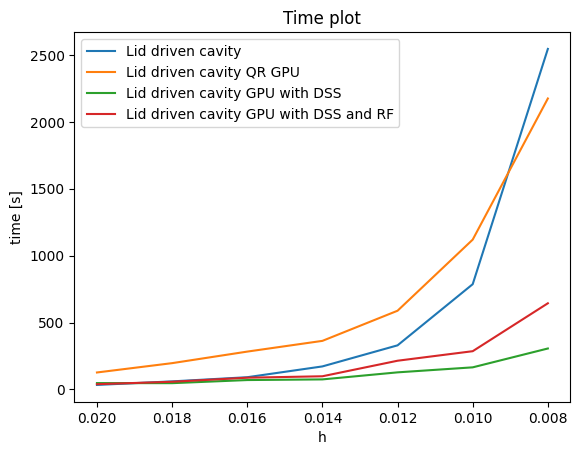

In [21]:
fig, ax = plt.subplots()
for name, (solver_u, solver_p) in programs.items():
    ts = []
    for h in hs:
        result_file = Path("..") / get_output_path(f"{solver_u}_{solver_p}", h)
        with h5py.File(result_file) as f:
            time = f.attrs["time"]
            ts.append(time)
    ax.plot(hs, ts, label=name)
plt.gca().invert_xaxis()
ax.set_xlabel('h')
ax.set_ylabel('time [s]')
ax.set_title("Time plot")
ax.legend()

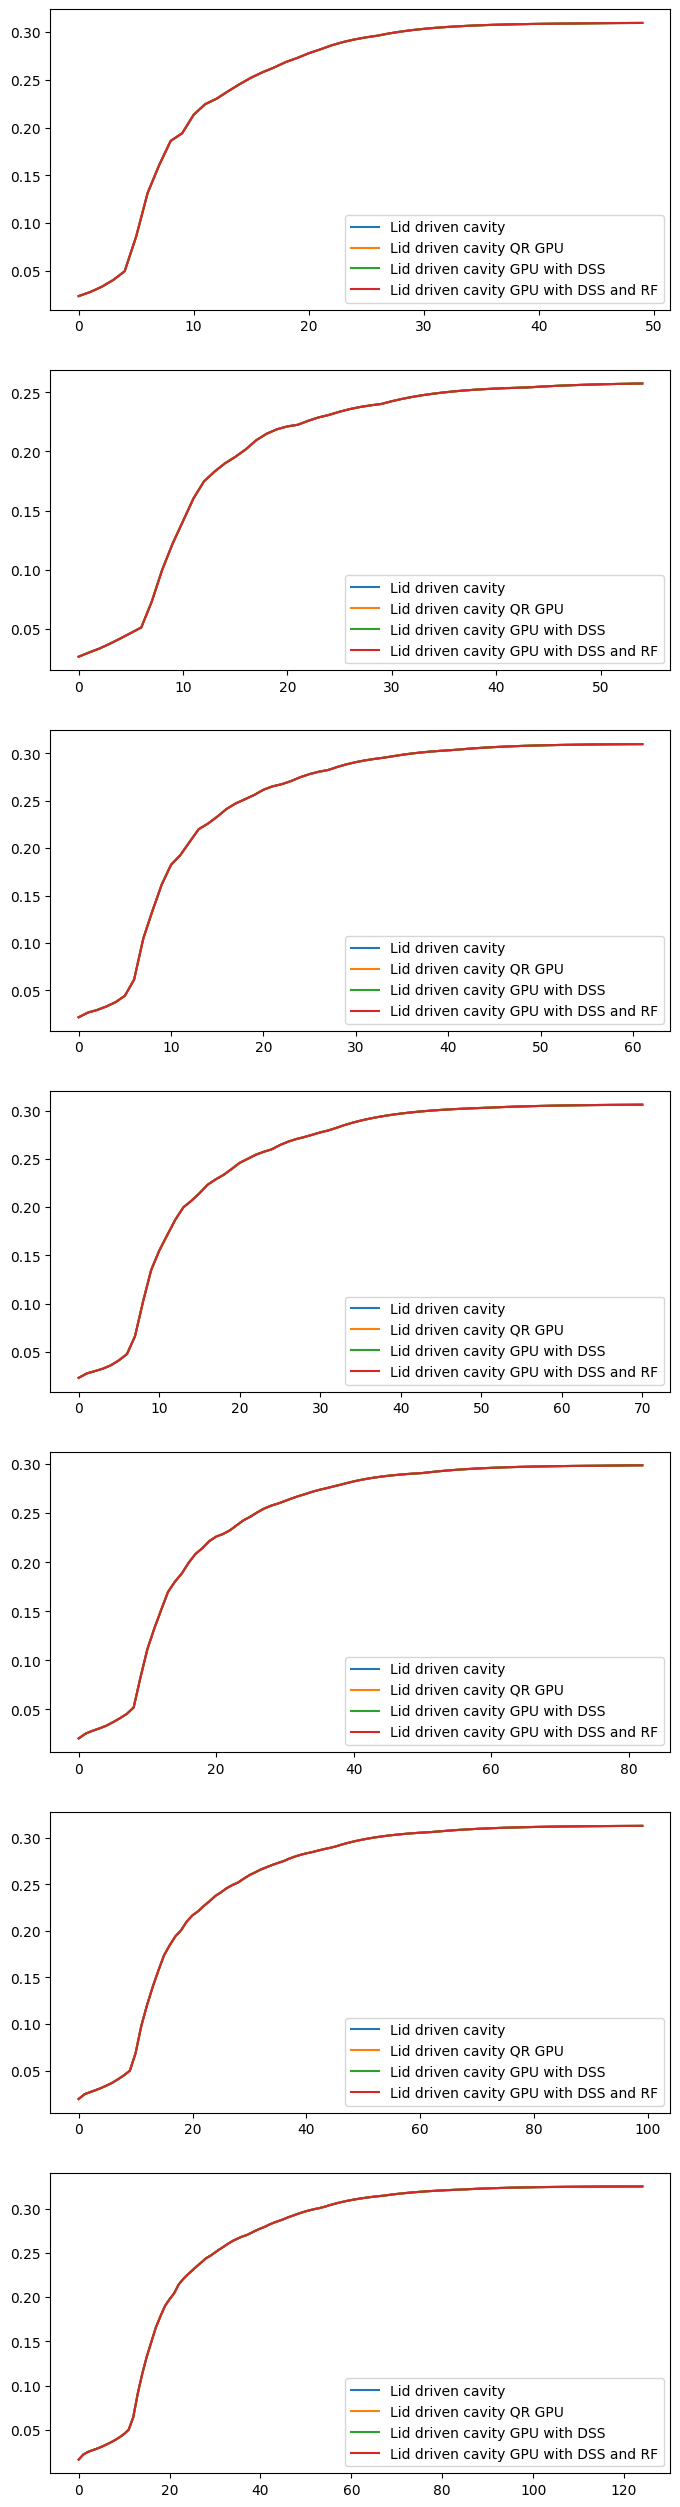

In [22]:
fig, axs = plt.subplots(len(hs), figsize=(8,32))
for i, h in enumerate(hs):
    for name, (solver_u, solver_p) in programs.items():
        result_file = Path('..') / get_output_path(f"{solver_u}_{solver_p}", h)
        with h5py.File(result_file) as f:
            velocity = np.array(f['max_u_y'], dtype=np.float64)
            xs = list(range(len(velocity[0])))
            axs[i].plot(xs, velocity[0], label=name)
            axs[i].legend()

Norm of difference between matrices that represent final velocity fields

In [23]:
cpu_program = 'Lid driven cavity'
gpu_program = "Lid driven cavity GPU with DSS"
for i, h in enumerate(hs):
    cpu_result_file = Path('..') / get_output_path(programs[cpu_program], h)
    with h5py.File(cpu_result_file) as f:
        velocity_cpu = np.array(f['velocity'], dtype=np.float64)
    gpu_result_file = Path('..') / get_output_path(programs[gpu_program], h)
    with h5py.File(gpu_result_file) as f:
        velocity_gpu = np.array(f['velocity'], dtype=np.float64)
    print(f"h = {h}:", np.linalg.norm(velocity_cpu - velocity_gpu))

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '../benchmark/lidDriven_('SparseLUWrapper', 'SparseLUWrapper')_20_result.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)